要模拟一个情景，其中有600个人站成一排，每次随机杀掉一个奇数位置的人，目的是找出哪个位置的人最安全。具体实现可以分为以下几个步骤和解释：

### 1. 问题理解

- **初始状态**：有600个人站成一排，编号从1到600。
- **杀人规则**：每一轮中，随机选择当前存活的奇数编号的人，杀掉他们。
- **最终目标**：运行多次模拟，统计每个人被杀的轮次，找出哪些编号的人最晚被杀，或者可能存活到最后。

### 2. 实现思路

实现的关键在于通过多次模拟，记录每个编号的人在每次模拟中被杀的轮次，然后通过统计找到最安全的位置。

### 3. 关键步骤解释

1. **`random_kill(n)` 和 `random_kill_list(alive_ids)` 函数**：
   - `random_kill(n)`：在给定范围内随机选择一个奇数位置的人。
   - `random_kill_list(alive_ids)`：从当前存活的人中，选择一个奇数位置的人进行淘汰。

2. **`run_simulation_numpy(num_people)` 函数**：
   - `ids`：表示所有人的编号，从1到600。
   - `status`：表示每个人的生存状态，1表示存活，0表示被淘汰。
   - `killed_turn`：记录每个人被淘汰的回合，初始值为-1表示尚未被淘汰。
   - 每轮循环中，`alive_ids`会筛选出当前存活的编号，然后随机淘汰其中一个奇数编号的人。
   - 淘汰后更新 `status` 和 `killed_turn`，最后将结果存储在一个DataFrame中。

3. **多次模拟**：
   - 通过循环运行 `run_simulation_numpy(num_people)` N次（例如20000次），在每次模拟中记录每个人的淘汰回合。
   - 结果存储在 `df_simul` DataFrame中，每一列表示一次模拟的结果。



In [145]:
z = 11
k = (z - z % 2) // 2
1 + (z - z % 2) // 2
import random

random.randrange(1, z + 1, 2)

3

In [146]:
import pandas as pd
import numpy as np
import random
import warnings
import seaborn as sns
from pylab import mpl, plt

# best font and style settings for notebook
warnings.filterwarnings('ignore')
sns.set_style("white")
mpl.rcParams['font.family'] = '微软雅黑'
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

# def random_kill(n):
#     # 生成一个随机的奇数，范围从0到n-1
#     return random.choice([i for i in range(n) if i % 2 == 0])

# def random_odd(n):
#     return random.randrange(1, n + 1, 2)

# def random_kill_list(alive_ids):
#     n = len(alive_ids)
#     random_odd_idx = random.randrange(1, n + 1, 2)
#     return alive_ids[random_odd_idx - 1]


def run_simulation_numpy(num_people):

    # 初始化 NumPy 数组
    ids = np.arange(1, num_people + 1)
    killed_turn = np.full(num_people, -1)  # 初始化淘汰回合
    turn_num = num_people

    for turn in range(turn_num):
        alive_ids = ids[killed_turn == -1]  # 获取当前存活的ID
        if len(alive_ids) == 0:  # 如果没有存活者，提前退出循环
            break

        random_odd_idx = random.randrange(1, len(alive_ids) + 1, 2)
        kill_id = alive_ids[random_odd_idx - 1] - 1  # 选择要淘汰的ID

        killed_turn[kill_id] = turn + 1  # 记录淘汰回合

    return killed_turn


# def run_simulation_numpy(num_people):
#     ids = np.arange(1, num_people + 1)
#     killed_turn = np.full(num_people, -1)

#     for turn in range(num_people):
#         alive_mask = killed_turn == -1
#         alive_ids = ids[alive_mask]

#         if alive_ids.size == 0:
#             break

#         kill_index = np.random.choice(np.arange(
#             len(alive_ids))[::2])  # 随机选择奇数索引
#         killed_turn[alive_mask][kill_index] = turn + 1

#     return killed_turn


#
num_people = 600
N = 35000
df_simul = pd.DataFrame({"id": range(1, 1 + num_people)})
for i in tqdm_notebook(range(N)):
    result_df = run_simulation_numpy(num_people)
    df_simul[f'turn_{i}'] = result_df


  0%|          | 0/35000 [00:00<?, ?it/s]

In [147]:
# df_simul.to_csv("simul.csv", index=False)

In [148]:
# df_simul.min().iloc[:-1].sum()

In [149]:
# df_simul.iloc[df_simul.iloc[:,1:].idxmax()]

,id,win_count
0,1,0
1,2,0
2,3,0
3,4,1
4,5,1
...,...,...
595,596,129
596,597,132
597,598,112
598,599,93


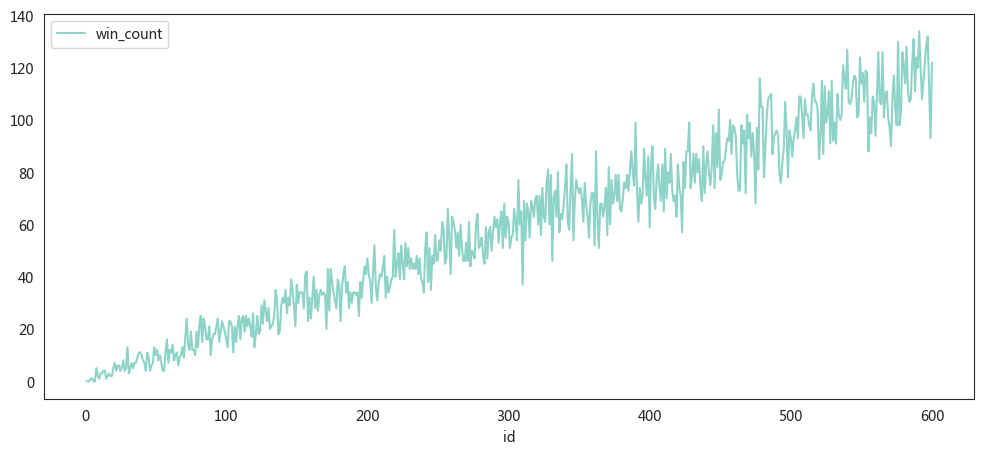

In [150]:
a = df_simul.iloc[:, 1:].idxmax().values + 1
b = np.array(range(1, 1 + num_people))
# pd.DataFrame(np.concatenate((a, b))).value_counts().sort_index().values - 1

last_killed_counts = pd.DataFrame({
    'id':
    b,
    'win_count':
    pd.DataFrame(np.concatenate((a, b))).value_counts().sort_index().values - 1
})
last_killed_counts.plot(x='id', y='win_count', figsize=(12, 5))
last_killed_counts

In [151]:
last_killed_counts.sort_values('win_count',ascending=False)

,id,win_count
590,591,134
596,597,132
586,587,131
575,576,130
595,596,129
...,...,...
2,3,0
1,2,0
5,6,0
6,7,0


In [152]:
df_simul['average_alive_turns'] = df_simul.T.mean()
df_simul[['id', 'average_alive_turns']].sort_values(by='average_alive_turns',
                                                    ascending=False)

,id,average_alive_turns
1,2,334.467130
3,4,322.646724
5,6,317.611154
7,8,314.787520
11,12,311.955944
...,...,...
8,9,282.373104
6,7,277.798920
4,5,270.733722
2,3,254.239850


<AxesSubplot:xlabel='id'>

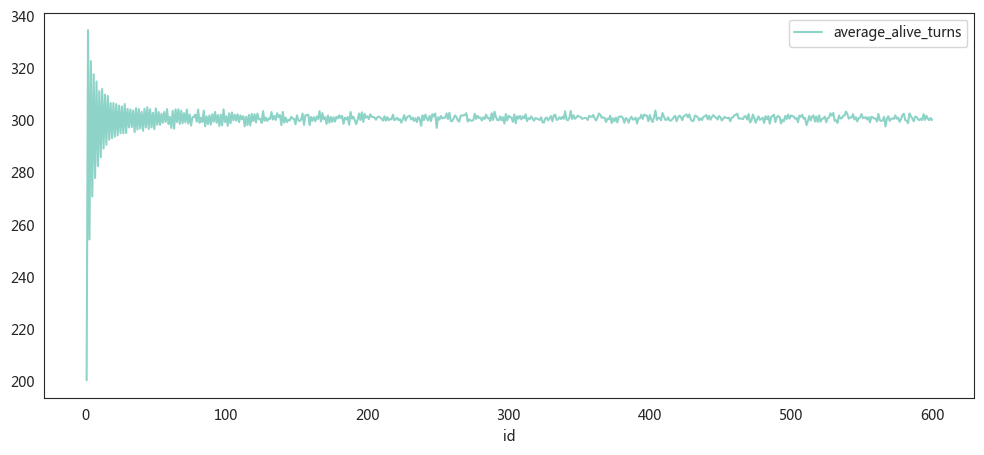

In [153]:
df_simul[['id', 'average_alive_turns']].plot(x='id',y='average_alive_turns',figsize=(12,5))

In [154]:
!jupyter nbconvert --to html random_kill_final.ipynb

[NbConvertApp] Converting notebook random_kill_final.ipynb to html
[NbConvertApp] Writing 419462 bytes to random_kill_final.html


In [155]:
!jupyter nbconvert --to markdown random_kill_final.ipynb

[NbConvertApp] Converting notebook random_kill_final.ipynb to markdown
[NbConvertApp] Support files will be in random_kill_final_files/
[NbConvertApp] Writing 8283 bytes to random_kill_final.md
